# Assignment of class MSP

Author: Hung Do (xdohun00@stud.fit.vutbr.cz)

Date: 15/12/2023

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import gamma, nbinom, truncnorm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Reading data from the file

In [3]:
# original data
df = pd.read_excel("./Projekt-2_Data.xlsx")

# renaming columns
col_map = {
    "uloha_1 a)": "poster_a",
    "uloha_1 b)_prior": "prior_b",
    "skupina": "groups",
    "uloha_1 b)_pozorování": "observation_b"
}
df1 = df.rename(columns=col_map)
df1

,poster_a,prior_b,groups,observation_b
0,2.0,3.634785,0,3.626656
1,2.0,2.868113,0,3.008269
2,1.0,2.149160,0,2.989829
3,3.0,4.263065,0,2.371630
4,0.0,2.594745,0,4.009366
...,...,...,...,...
99995,NaN,1.725637,9999,NaN
99996,NaN,4.048414,9999,NaN
99997,NaN,3.000662,9999,NaN
99998,NaN,3.058451,9999,NaN


# Bayesian Probability

### Prior and posterior probability distribution of Poisson distribution parameter λ

Pro výpočet apriorního a aposteriorního rozdělení parametru $\lambda$ můžeme použít tabulku konjugovaných rozdělení (viz. odkaz na Wiki). Z ní můžeme vyčíst, že Poissonovo rozdělení můžeme vygenerovat pomocí Gamma rozdělení. Proto použijeme funkci `scipy.stats.gamma`.

Hodnota $\alpha$ označuje četnost nějakého jevu a hodnota $\beta$ označuje délku časového úseku, během kterého experiment proběhl.

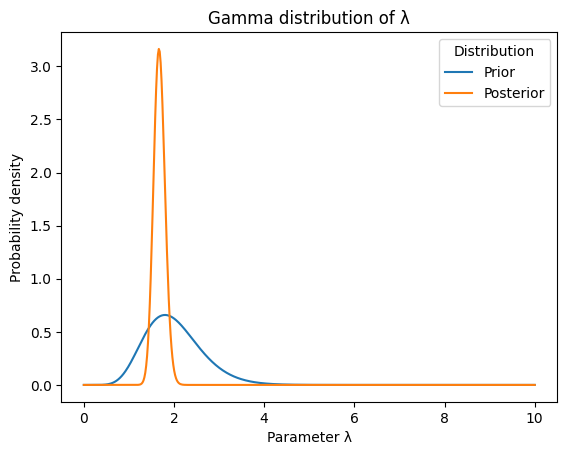

In [4]:
# clear data since there are lots of NaN values
# which messes with the calculation
data = df1["poster_a"].dropna()

# defining some constant values 
x = np.linspace(0, 10, 500)
alpha, beta = 10, 5
alpha_post = alpha + data.sum()
beta_post = beta + data.size

# calculate prior and posterior distributions
# using Gamma distribution
prior_1a1 = gamma(alpha, scale=1/beta)
posterior_1a1 = gamma(
    alpha + data.sum(),
    scale=1 / (beta + data.size)
)

# plot a graph
fig, ax = plt.subplots()
_ = ax.plot(x, prior_1a1.pdf(x), label="Prior")
_ = ax.plot(x, posterior_1a1.pdf(x), label="Posterior")
_ = plt.legend(title="Distribution")
_ = ax.set(title="Gamma distribution of λ", xlabel="Parameter λ", ylabel="Probability density")


### Predictive distributions

Prediktivní rozdělení apriorní a aposteriorní se dá vypočítat pomocí $NB$ (Negativní Binomické rozdělení). Vzorce pro $\alpha$ a $\beta$ jsou byly opět převzaté z Wiki stránky.

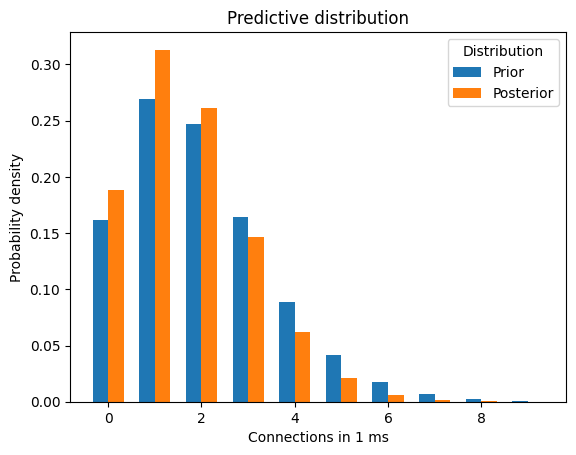

In [5]:

# create a smaller range
x2 = np.arange(0, 10)

# predictive distributions of the Poisson distribution
# is negative binomial distribution
prior_1a2 = nbinom(alpha, beta/(1 + beta))
posterior_1a2 = nbinom(alpha_post, beta_post / (1 + beta_post))

# plot graph
WIDTH=0.5 / 1.5
fig, ax = plt.subplots()
_ = ax.bar(x2 - WIDTH / 2, prior_1a2.pmf(x2), label="Prior", width=WIDTH)
_ = ax.bar(x2 + WIDTH / 2, posterior_1a2.pmf(x2), label="Posterior", width=WIDTH)
_ = plt.legend(title="Distribution")
_ = ax.set(title="Predictive distribution", xlabel="Connections in 1 ms", ylabel="Probability density")

### Confidence interval
Každé rozdělení v knihovně `scipy.stats` obsahuje funkci `interval`, která vypočítá hraniční body intervalu se zadanou spolehlivostí. Tyto hodnoty pak zobrazíme v grafu.

95 %% interval spolehlivosti parametru λ pro aposteriorní rozložení: (1.4376938284869922, 1.9327207471868797)
95 %% interval spolehlivosti parametru λ pro apriorní rozložení: (0.9590777392264868, 3.416960690283833)


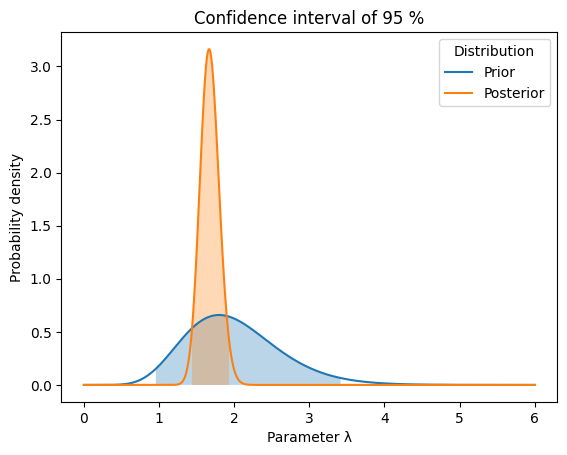

In [6]:
# define range constant
# calculate a range of the confidence interval of 95 %
# scipy.stats.[distribution] contains a `interval` function
# that returns the starting and ending values for the distribution
x = np.linspace(0, 6, 500)
conf_int_prior = prior_1a1.interval(0.95)
conf_int_posterior = posterior_1a1.interval(0.95)

x_prior = np.linspace(conf_int_prior[0], conf_int_prior[1], 500)
x_posterior = np.linspace(conf_int_posterior[0], conf_int_posterior[1], 500)
print("95 %% interval spolehlivosti parametru λ pro aposteriorní rozložení:", conf_int_posterior)
print("95 %% interval spolehlivosti parametru λ pro apriorní rozložení:", conf_int_prior)

# plot graph
fig, ax = plt.subplots()
_ = ax.plot(x, prior_1a1.pdf(x), label="Prior")
_ = ax.plot(x, posterior_1a1.pdf(x), label="Posterior")
_ = plt.legend(title="Distribution")
_ = ax.set(title="Confidence interval of 95 %", xlabel="Parameter λ", ylabel="Probability density")
_ = ax.fill_between(x_prior, prior_1a1.pdf(x_prior), alpha=.3)
_ = ax.fill_between(x_posterior, posterior_1a1.pdf(x_posterior), alpha=.3)

### Point estimators

Jako bodové odhady parametru jsem porovnal 2 možné výpočty: **aritmetický průměr** a **medián**. Jelikož tvar aposteriorního rozležení parametru $\lambda$ je velmi úzký (malý rozptyl) a jeho tvar hodně pripomíná normální rozdělení, tak bodové odhady budou mít velmi podobnou hodnotu. Což nám dokládá i náš výpočet. Bodové odhady podle mediánu a střední hodnoty se liší v řádech tisícin. 

Rozptyl aposteriorního rozložení: 0.1263
Bodový odhat parametru λ podle mediánu: 1.6761904761904765
Bodový odhat parametru λ podle střední hodnoty: 1.6730169441241727


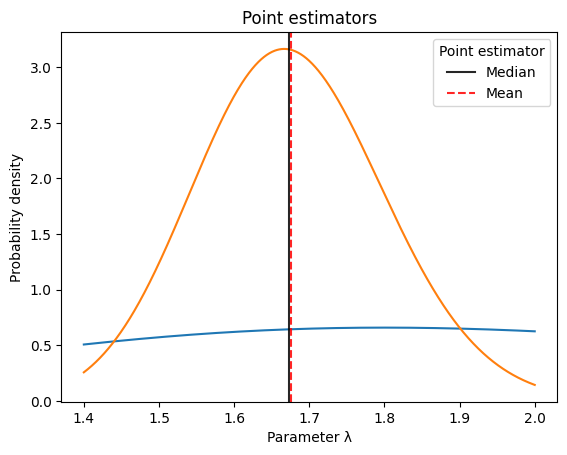

In [7]:
# point estimators - mean, mode, and median
point_estimator_1 = posterior_1a1.mean()
point_estimator_2 = posterior_1a1.median()
x = np.linspace(1.4, 2, 1000)

# plot graph
fig, ax = plt.subplots()
_ = ax.plot(x, prior_1a1.pdf(x))
_ = ax.plot(x, posterior_1a1.pdf(x))
_ = ax.set(title="Point estimators", xlabel="Parameter λ", ylabel="Probability density")
# plot the point estimators
_ = ax.axvline(x=point_estimator_2, alpha=0.85, color="k", linestyle="-", label="Median")
_ = ax.axvline(x=point_estimator_1, alpha=0.85, color="r", linestyle="--", label="Mean")
_ = plt.legend(title="Point estimator")

print(f"Rozptyl aposteriorního rozložení: {posterior_1a1.std():.4f}")
print(f"Bodový odhat parametru λ podle mediánu: {point_estimator_1}")
print(f"Bodový odhat parametru λ podle střední hodnoty: {point_estimator_2}")

### Point estimators for predictive distribution

Pro výpočet bodových odhadů prediktivní apriorní a apostriorní distribuce (rozložení) byla použita **střední hodnota**.

In [8]:
print(f"Bodový odhad počtu pozorování aposteriorního rozložení: {posterior_1a2.mean():.4f}")
print(f"Bodový odhad počtu pozorování apriorního rozložení: {prior_1a2.mean():.4f}")

Bodový odhad počtu pozorování aposteriorního rozložení: 1.6762
Bodový odhad počtu pozorování apriorního rozložení: 2.0000


# Approximation using discrete distribution

### Prior, posterior distributions and likelihood function
Jelikož se snažíme odhadnout parametr $b$, kde $b$ značí **maximální** dobu trvání procesu, ze zadaných skupin vybereme maximální hodnoty a zakreslíme je do histogramu. V této práci chceme pracovat s až 50 hodnotami $b$ (proto rozdělíme histogram do 50 "binů"). Najdeme středy binů a to jsou pro nás parametry $b$. Jejich váha je pak definována jako výška histogramu.

Následně vypočítáme ostatní hodnoty (funkce věrohodnosti a aposteriorní rozdělení) podle vzorce Bayesové pravděpodobnosti:

$$P(b_i|X) = \frac{P(X|b_i) \cdot P(b_i)}{\Sigma_{j=1}^{n} P(X|b_j) \cdot P(b_j)} $$

kde $P(b_i|X)$ je aposteriorní pravděpodobnost pro parametr $b_i$ a $P(X|b_i)$ je věrohodnostní funkce s parametrem $b_i$

In [9]:
# init variables
a = 1
_mu = 3
_sigma = 1 # sqrt(_var)
alpha = (a - _mu) / _sigma

data_group_max = df1.groupby("groups").max()["prior_b"]
data_observe_b = df1["observation_b"].dropna()

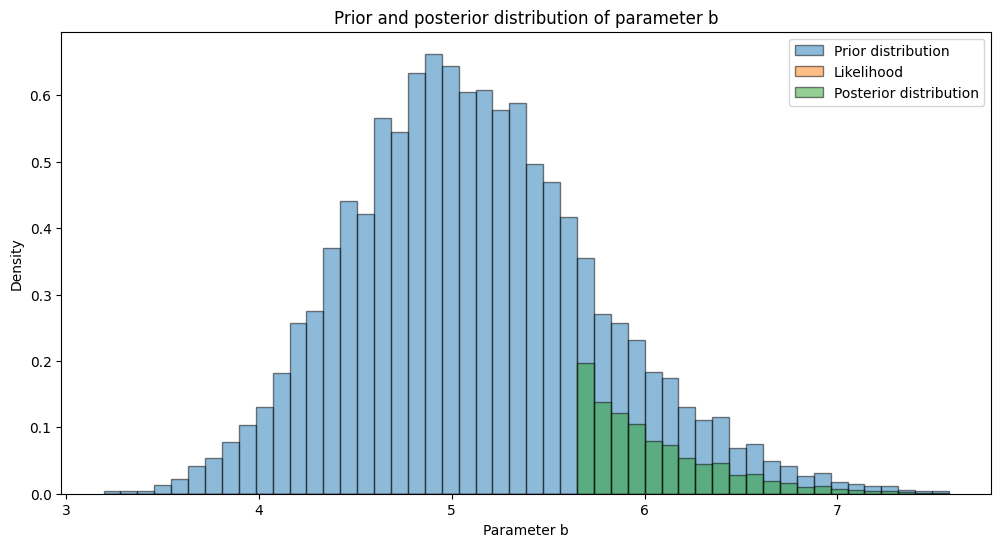

In [10]:
# get the maximum of each group
fig, ax = plt.subplots(figsize=(12, 6))

# get prior distribution of parameter b
_h_b, _b = np.histogram(data_group_max, bins=50, density=True)
mid_bins = np.diff(_b) / 2 + _b[:-1]
WIDTH = np.diff(mid_bins)[0]
ax.bar(mid_bins, _h_b, edgecolor="k", width=WIDTH, alpha=.5, label="Prior distribution")

# calculate likelihood for each b parameter
# the base distribution is a truncated normal
evidence = 0
likelihoods = []
for i, b in enumerate(mid_bins):
    # likelihood for parameter b is a product of all p(X|b)
    # where X is vector of observed values
    beta = (b - _mu) / _sigma
    p_X_b = [truncnorm(a=alpha, b=beta, loc=_mu, scale=_sigma).pdf(x) for x in data_observe_b]
    likelihood = np.prod(p_X_b)
    likelihoods.append(likelihood)
    # evidence is a sum of all [likelihood * prior]
    evidence += likelihood * _h_b[i]

ax.bar(mid_bins, likelihoods, width=WIDTH, alpha=.5, edgecolor="k", label="Likelihood")

# calculating posterior distribution
# posterior = likelihood * prior / evidence
posterior_1b1 = [likelihoods[i] * h_b / evidence for i, h_b in enumerate(_h_b)]
ax.bar(mid_bins, posterior_1b1, width=WIDTH, alpha=.5, edgecolor="k", label="Posterior distribution")

_ = ax.set(title="Prior and posterior distribution of parameter b", xlabel="Parameter b", ylabel="Density")
_ = ax.legend()

Zde lze vidět (nebo spíše nejde vidět) graf, kde hodnoty nejsou normalizované. Ve spodním výpočtu je toto spraveno a můžeme tu vidět všechny 3 rozdělení.

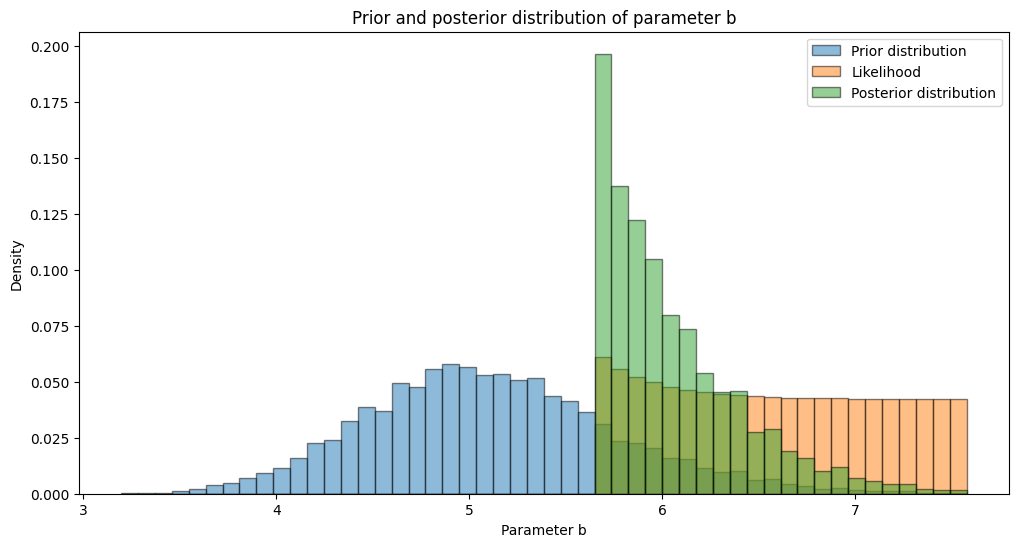

In [11]:
# normalizing data to make data visible
fig, ax = plt.subplots(figsize=(12, 6))

# get prior distribution of parameter b
_h_b, _b = np.histogram(data_group_max, bins=50)
_h_b = np.array(_h_b) / 10000
mid_bins = np.diff(_b) / 2 + _b[:-1]
WIDTH = np.diff(mid_bins)[0]

evidence = 0
likelihoods = []
for i, b in enumerate(mid_bins):
    # likelihood for parameter b is a product of all p(X|b)
    # where X is vector of observed values
    beta = (b - _mu) / _sigma
    p_X_b = [truncnorm(a=alpha, b=beta, loc=_mu, scale=_sigma).pdf(x) for x in data_observe_b]
    likelihood = np.prod(p_X_b)
    likelihoods.append(likelihood)
    # evidence is a sum of all [likelihood * prior]
    evidence += likelihood * _h_b[i]


# plot graphs
ax.bar(mid_bins, _h_b, edgecolor="k", width=WIDTH, alpha=.5, label="Prior distribution")
ax.bar(mid_bins, np.array(likelihoods) / np.sum(likelihoods), width=WIDTH, alpha=.5, edgecolor="k", label="Likelihood")
posterior_1b1 = [likelihoods[i] * h_b / evidence for i, h_b in enumerate(_h_b)]
ax.bar(mid_bins, posterior_1b1, width=WIDTH, alpha=.5, edgecolor="k", label="Posterior distribution")

_ = ax.set(title="Prior and posterior distribution of parameter b", xlabel="Parameter b", ylabel="Density")
_ = ax.legend()

Interval spolehlivosti diskrétních hodnot se počítá přes distribuční funkci. U ní hledáme dolní a horní hranice hodnot parametru $b$, kdy výsledek distribuční funkce $f(b)$ je menší než 0.025 a větší než 0.975.

In [30]:
cumulative_sum = np.cumsum(posterior_1b1)
lower_bound = np.max(mid_bins[cumulative_sum <= 0.025])
upper_bound = np.min(mid_bins[cumulative_sum >= 0.975])

print(f"95 % interval spolehlivosti parametru b pro aposteriorní rozložení: {lower_bound}, {upper_bound}")


95 % interval spolehlivosti parametru b pro aposteriorní rozložení: 5.606032121504683, 7.008910628347767


Jako 2 bodové odhady jsem znovu zvolil *medián* a *střední hodnotu*.

In [13]:
# median
median = np.max(mid_bins[cumulative_sum <= 0.5])
mean = sum(mid_bins * posterior_1b1)

print(f"Bodový odhad podle mediánu: {median}")
print(f"Bodový odhad podle střední hodnoty: {mean}")

Bodový odhad podle mediánu: 5.86907184153776
Bodový odhad podle střední hodnoty: 6.052771319832351


# Regrese

V druhé části se zaměříme na regresní analýzu dat. Dataset obsahuje 5 sloupců: `OSType`, `ActiveUsers`, `InteractingPct`, `ScrollingPct`, `Ping [ms]`. Naším úkolem je vytvořit model, který nám pomůže odhadnout hodnotu `Ping [ms]` na základě nezávislých hodnot. Podíváme-li se na data letno, můžeme si všimnou negativní korelace mezi `InteractingPct` a `ScrollingPct`. Jejich součet je vždy 1. Pro naší analýzu můžeme tedy jeden z těchto sloupců (vybráno `ScrollingPct`) odstranit.

In [14]:
df2_orig = pd.read_excel("./Projekt-2_Data.xlsx", sheet_name=1)
df2_orig

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping [ms]
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39


In [15]:
def print_vif(model):
    """Function that calculates VIF for a given model.

    The result is printed on STDOUT.
    
    Args:
        model: Given OLS model.
    """
    X = pd.DataFrame(model.exog, columns=model.exog_names)
    vif = pd.Series([variance_inflation_factor(X.values, i) 
                     for i in range(X.shape[1])], 
                     index=X.columns)
    vif_df = vif.to_frame()
    # Nastavení názvu sloupce
    vif_df.columns = ['VIF']
    print('\n')
    print(vif_df)
    #ukaž korelaci prediktorů
    print('\n')
    print(X.corr())

Nejprve si upravíme náš dataset, aby se nám s ním lépe pracovalo. Sloupec `OSType` přeměníme na kategorický a uděláme z něj dummy variables (metoda *one-hot*). Následně odstraníme sloupec `ScrollingPct`, přejmenujeme názvy sloupců na jejich kratší alias a vygenerujeme chybějící interakce druhého řádu a druhých mocnin, abych dostali "plný" model.

In [16]:
df2 = df2_orig.copy()
df2["OSType"] = df2["OSType"].astype("category")
df2_dummies = pd.get_dummies(df2, drop_first=True)

# dropping a column that has a strong corelation with another column
df2_dummies = df2_dummies.drop(columns=["ScrollingPct"])

# renaming column to retain my last drop of sanity
# after working on this project for a week already
df2_dummies = df2_dummies.rename(columns={
    "ActiveUsers": "AU",
    "InteractingPct": "IP",
    "Ping [ms]": "Ping",
    "OSType_MacOS": "mac",
    "OSType_Windows": "win",
    "OSType_iOS": "ios",
})

# generating "full" model
df2_dummies["AU2"] = df2_dummies["AU"] ** 2
df2_dummies["IP2"] = df2_dummies["IP"] ** 2
df2_dummies["AUIP"] = df2_dummies["AU"] * df2_dummies["IP"]

# os
df2_dummies["win_AU"] = df2_dummies["AU"] * df2_dummies["win"]
df2_dummies["win_IP"] = df2_dummies["IP"] * df2_dummies["win"]
df2_dummies["mac_AU"] = df2_dummies["AU"] * df2_dummies["mac"]
df2_dummies["mac_IP"] = df2_dummies["IP"] * df2_dummies["mac"]
df2_dummies["ios_AU"] = df2_dummies["AU"] * df2_dummies["ios"]
df2_dummies["ios_IP"] = df2_dummies["IP"] * df2_dummies["ios"]

df2_dummies = df2_dummies.astype(float)
df2_dummies

,AU,IP,Ping,mac,win,ios,AU2,IP2,AUIP,win_AU,win_IP,mac_AU,mac_IP,ios_AU,ios_IP
0,4113.0,0.8283,47.0,0.0,0.0,1.0,16916769.0,0.686081,3406.7979,0.0,0.0000,0.0,0.0000,4113.0,0.8283
1,7549.0,0.3461,46.0,0.0,0.0,1.0,56987401.0,0.119785,2612.7089,0.0,0.0000,0.0,0.0000,7549.0,0.3461
2,8855.0,0.2178,55.0,0.0,1.0,0.0,78411025.0,0.047437,1928.6190,8855.0,0.2178,0.0,0.0000,0.0,0.0000
3,8870.0,0.0794,56.0,0.0,0.0,0.0,78676900.0,0.006304,704.2780,0.0,0.0000,0.0,0.0000,0.0,0.0000
4,9559.0,0.7282,76.0,1.0,0.0,0.0,91374481.0,0.530275,6960.8638,0.0,0.0000,9559.0,0.7282,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,5315.0,0.1974,28.0,0.0,0.0,1.0,28249225.0,0.038967,1049.1810,0.0,0.0000,0.0,0.0000,5315.0,0.1974
498,1392.0,0.2373,24.0,1.0,0.0,0.0,1937664.0,0.056311,330.3216,0.0,0.0000,1392.0,0.2373,0.0,0.0000
499,6014.0,0.8112,54.0,0.0,0.0,1.0,36168196.0,0.658045,4878.5568,0.0,0.0000,0.0,0.0000,6014.0,0.8112
500,5118.0,0.2345,39.0,0.0,0.0,0.0,26193924.0,0.054990,1200.1710,0.0,0.0000,0.0,0.0000,0.0,0.0000


Nyní provedeme analýzu plného modelu, než z něj začneme odstraňovat prediktory. Z výsledného výpisu nás zajímají tyto informace:

- `R-squared` - koeficient determinizace
- `Adj. R-squared` - koeficient determinizace, na který má vliv počet prediktorů
- `Prob (F-statistics)` - testovací kritérium celého modelu; nulová hypotéza $H_0$ nám povídá, že všechny koeficienty prediktorů jsou rovny 0 (neboli prediktory jsou pro model irelevantní)
- `P>|t|` - testovací kritérium pro jednotilivé koeficienty prediktorů. Pokud je *p-hodnota* větší než O.05 (pro 95 % interval spolehlivosti), pak je daný prediktor pro model irelevantní.

Z výpočtu `P>|t|` vidíme seznam prediktorů, které nejsou pro náš model moc relevantní (jejich p-hodnota je větší než 0.05, tím pádem nezamítáme hypotézu $H_0$, že koeficient prediktoru je rovno nule).

In [17]:
y = df2_dummies["Ping"]
X = df2_dummies.drop(columns=["Ping"])
X_ols = sm.add_constant(X)

# get base model
model = sm.OLS(y, X_ols)
result = model.fit()
print(result.summary())

# VIF of the base class
print_vif(model)

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        14:29:40   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3388      2.354     -0.144      0.8

V tabulce se nachází mnoho "přebytečných" prediktorů. Poznámeje tak, že jejich p-hodnota (sloupec `P>|t|`) je větší než 0.05. V následující části iterativně budeme odstraňovat sloupce s nejvyšší p-hodnotou, dokud nám nezůstanou jenom podstatné prediktory.

Nakonec model otestujeme na *multikolinearitu* a odstraníme sloupec `AU2`.

In [18]:
# starting to eliminate columns
X_ols_new = X_ols.drop(columns=["ios", "ios_IP", "win_IP", "mac_IP", "IP2", "mac", "AU2"])
model = sm.OLS(y, X_ols_new)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     309.3
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          4.99e-176
Time:                        14:29:40   Log-Likelihood:                -1642.0
No. Observations:                 502   AIC:                             3300.
Df Residuals:                     494   BIC:                             3334.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9196      1.357      7.309      0.0

In [19]:
print_vif(model)



              VIF
const   22.411971
AU       4.567019
IP       5.561726
win      5.546736
AUIP     8.550677
win_AU   6.464752
mac_AU   1.656643
ios_AU   1.550671


        const        AU        IP       win      AUIP    win_AU    mac_AU  \
const     NaN       NaN       NaN       NaN       NaN       NaN       NaN   
AU        NaN  1.000000  0.040275  0.003135  0.591746  0.258029  0.243697   
IP        NaN  0.040275  1.000000 -0.016964  0.752979  0.010807  0.072359   
win       NaN  0.003135 -0.016964  1.000000  0.002608  0.875271 -0.327426   
AUIP      NaN  0.591746  0.752979  0.002608  1.000000  0.163826  0.193768   
win_AU    NaN  0.258029  0.010807  0.875271  0.163826  1.000000 -0.286586   
mac_AU    NaN  0.243697  0.072359 -0.327426  0.193768 -0.286586  1.000000   
ios_AU    NaN  0.189859 -0.050601 -0.290521  0.053582 -0.254284 -0.261236   

          ios_AU  
const        NaN  
AU      0.189859  
IP     -0.050601  
win    -0.290521  
AUIP    0.053582  
win_AU -0.254284  
mac_AU 

### Model after basic predictor eliminations

Náš výsledný model můžeme popsat touto rovnicí:
$$\small
y = 9.9196 + 0.0055x_{AU} + 35.2710x_{IP} + 7.7665C_{win} - 0.0033x_{AU}x_{IP} - 0.0007 C_{win}x_{AU} + 0.0017C_{mac}x_{AU} - 0.0010C_{ios}x_{AU}
$$

kde:
- $x_{AU}$ je prediktor `ActiveUsers`,
- $x_{IP}$ je prediktor `InteractingPct`
- $C_{OSType}$ jsou kategorické prediktory operačních systémů.

V následující buňce pak vykreslíme graf tohoto modelu ve 3D prostoru.

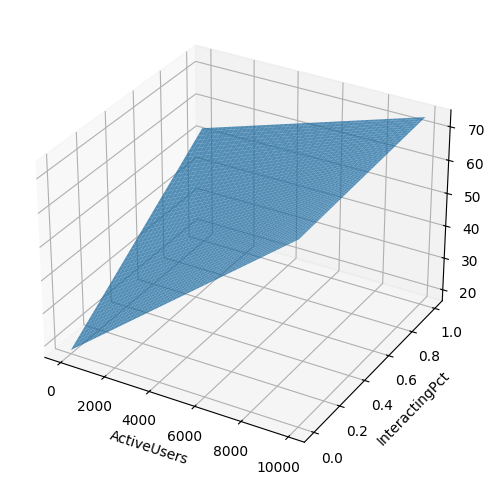

In [20]:
# plot graph
X1 = np.arange(0, 10000, 50)
X2 = np.arange(0, 1, 0.005)
X1, X2 = np.meshgrid(X1, X2)
Y = (            result.params.iloc[0]  # const
     + X1 *      result.params.iloc[1]  # ActiveUsers
     + X2 *      result.params.iloc[2]  # InteractingPct
     +           result.params.iloc[3]  # Windows
     + X1 * X2 * result.params.iloc[4]  # ActiveUsers * InteractingPct
     + X1 *      result.params.iloc[5]  # Windows * ActiveUsers
     + X1 *      result.params.iloc[6]  # MacOS * ActiveUsers
     + X1 *      result.params.iloc[7]) # iOS * ActiveUsers

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6, 6))
_ = ax.plot_surface(X1, X2, Y, alpha=0.75)
_ = ax.set(xlabel="ActiveUsers", ylabel="InteractingPct")
_ = ax.set_zlabel("Ping", rotation=90)

Můžeme si vykreslit graf pro jednotlivé operační systémy

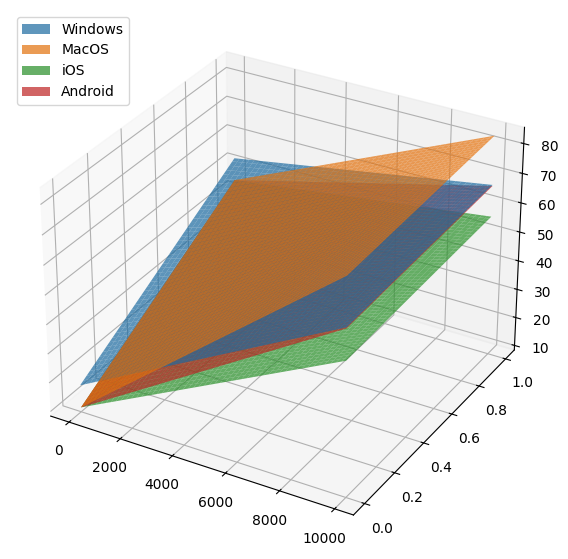

In [21]:
def get_y(os, result, x1, x2):
    if os == "win":
        return (        result.params.iloc[0]
            + x1 *      result.params.iloc[1]
            + x2 *      result.params.iloc[2]
            + x1 * x2 * result.params.iloc[4]
            +           result.params.iloc[3]
            + x1 * result.params.iloc[5]
        )
    elif os == "mac":
        return (         result.params.iloc[0]
             + x1 *      result.params.iloc[1]
             + x2 *      result.params.iloc[2]
             + x1 * x2 * result.params.iloc[4]
             + x1 *      result.params.iloc[6]
        )
    elif os == "ios":
        return (         result.params.iloc[0]
             + x1 *      result.params.iloc[1]
             + x2 *      result.params.iloc[2]
             + x1 * x2 * result.params.iloc[4]
             + x1 *      result.params.iloc[7]
        )
    elif os == "and":
        return (            result.params.iloc[0]
             + x1 *      result.params.iloc[1]
             + x2 *      result.params.iloc[2]
             + x1 * x2 * result.params.iloc[4]
        )

# plot for each OSType
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7, 7))
_ = ax.plot_surface(X1, X2, get_y("win", result, X1, X2), alpha=0.7, label="Windows")
_ = ax.plot_surface(X1, X2, get_y("mac", result, X1, X2), alpha=0.7, label="MacOS")
_ = ax.plot_surface(X1, X2, get_y("ios", result, X1, X2), alpha=0.7, label="iOS")
_ = ax.plot_surface(X1, X2, get_y("and", result, X1, X2), alpha=0.7, label="Android")
_ = ax.legend(loc="upper left")

### Outliers
V této části se pokusíme identifikovat *odlehlé body* v datasetu, odstraníme je a aktualizujeme náš model. Nejprve si vykreslíme graf, kde porovnáme predikované hodnoty s reálnými testovacími. V ideálním případě by včechny body měly ležet v blízkosti červené přímky. Zde můžeme vidět, že v datasetu se nejspíš nachází 2 odlehlé body (jsou nejdále od červené přímky, jejich `resid` je nad 30).

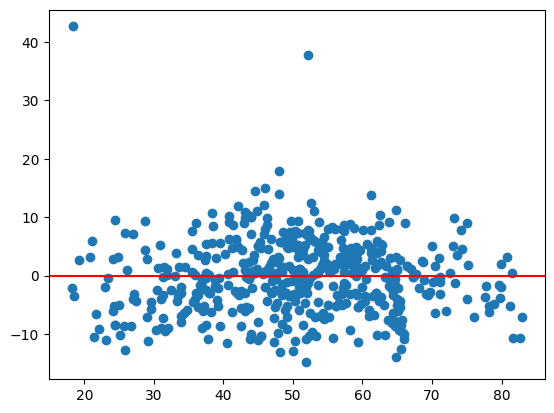

In [22]:
plt.scatter(result.fittedvalues, result.resid)
_ = plt.axhline(y=0, color="r")

Pomocí funkce `outlier_test` testujeme odlehlé body na našich pozorovaných datech. Jako výchozí metoda je použita **Bonferroniho korekce** na hladině spolehlivosti 95 %. Data, u kterých vyjde jako výsledek této korelace hodnota menší než 0.05 budeme brát za odlehlou hodnotu. Z testu získáme indexy těchto dat a z datasetu je odstraníme. Následně znovu otestujeme náš model. 

Nový model má lepší hodnotu `R-squared` (z 0.814 na 0.842). Upravený model můžeme popsat touto rovnicí:
$$\small
y = 8.5942 + 0.0057x_{AU} + 36.6538x_{IP} + 8.1826C_{win} - 0.0035x_{AU}x_{IP} - 0.0008C_{win}x_{AU} + 0.0017C_{mac}x_{AU} - 0.0010C_{ios}x_{AU}

$$

Nyní zkontrolujme náš model. Pokud budeme analyzovat výpis informací o modelu, dospějeme k závěru, že náš model splňuje předpoklady lineární regrese. 
- hodnota `R-squared` je vysoká, (model vysvětluje 84.2 % změn hodnoty odezvy)
- `Prob (F-statistic)` je menší než 0.05, což znamená, že náš výběr prediktorů je statisticky signifikantní
- `P > |t|` všech prediktorů je též menší než 0.05, tudíž každý prediktor v modelu má vliv na výpočet výsledné hodnoty odezvy
- hodnota `Durbin/Watson`ova testu leží v intervalu $\left[1, 2\right]$, tudíž neexistuje autokorelace mezi sousedními rezidui

Model je samozřejmě deformovaný, protože jsme neprovedli standardizaci. Po standardizaci by nám vyšel stejný model s různými koeficienty a významnostmi.

In [23]:
# get outliers
# source: https://notebook.community/samuelsinayoko/kaggle-housing-prices/research/outlier_detection_statsmodels
outlier_test = result.outlier_test()
outlier_indices = outlier_test.index[outlier_test["bonf(p)"] < 0.05].to_list()

y_without_outliers = y.drop(outlier_indices)
X_ols_without_outliers = X_ols_new.drop(outlier_indices)

# test an updated model
model = sm.OLS(y_without_outliers, X_ols_without_outliers)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     374.2
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.71e-192
Time:                        14:29:43   Log-Likelihood:                -1592.3
No. Observations:                 500   AIC:                             3201.
Df Residuals:                     492   BIC:                             3234.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5942      1.259      6.827      0.0

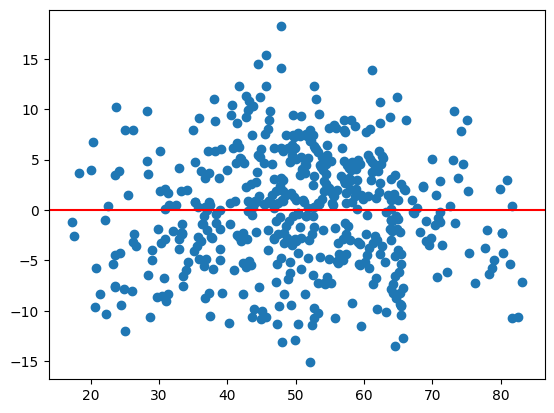

In [24]:
_ = plt.scatter(result.fittedvalues, result.resid)
_ = plt.axhline(y=0, color="r")


### Problematic values

Pro nás je problematické nastavení prediktorů, který vrací největší hodnotu odezvy. Nalezneme tedy jeho index a získáme jeho nastavení parametrů.

In [25]:
index = result.predict().argmax()
X_ols_without_outliers.iloc[index]

const        1.0000
AU        9953.0000
IP           0.6729
win          0.0000
AUIP      6697.3737
win_AU       0.0000
mac_AU    9953.0000
ios_AU       0.0000
Name: 227, dtype: float64

### Predict a value

Nyní se pokusíme odhadnout hodnotu odezvy pro uživatele *Windows*, při průměrném nastavení ostatních parametrů. Následně vypíšeme i jejich konfidenční a prediktivní itervaly.

In [26]:
x1_3b = X_ols_new["AU"].mean()
x2_3b = X_ols_new["IP"].mean()
print(f"Odhadovaná hodnota odezvy: {get_y('win', result, x1_3b, x2_3b)} ms")

kw = np.array([
    1,
    X_ols_new["AU"].mean(),
    X_ols_new["IP"].mean(),
    1,
    X_ols_new["AU"].mean() * X_ols_new["IP"].mean(),
    X_ols_new["AU"].mean(),
    0,
    0
])
prediction = result.get_prediction(kw)
pred_frame = prediction.summary_frame(alpha=0.05)
obs_ci_lower, obs_ci_upper = pred_frame.iloc[0][["obs_ci_lower", "obs_ci_upper"]]
mean_ci_lower, mean_ci_upper = pred_frame.iloc[0][["mean_ci_lower", "mean_ci_upper"]]

print(f"Konfidenční interval je ohraničen těmito body: {obs_ci_lower}, {obs_ci_upper}")
print(f"Predikční interval je ohraničen těmito body: {mean_ci_lower}, {mean_ci_upper}")


Odhadovaná hodnota odezvy: 51.81168875513785 ms
Konfidenční interval je ohraničen těmito body: 40.19035390049061, 63.43302360978511
Predikční interval je ohraničen těmito body: 50.80614933093145, 52.81722817934427


### Final summary

Jak již bylo řečené v předchozích buňkách, výpis informací modelu nám ukazuje, že máme dobrý model. Podíváme-li se na grafy pro jednotlivé operační systémy, můžeme z něj vyčíst, že s rostoucím počtem **aktivních uživatelů** roste i predikovaná **hodnota odezvy**. Logicky tento výrok dává smysl, nicméně ne vždy to musí platit. Hodnota `InteractingPct` má větší vliv na odezvě jen při malém počtu aktivních uživatelů. 

Nalezený model považuju za nejspíš vhodným a můžeme podle něj predikovat hodnoty odezvy, pokud počet aktivních uživatelů nepřesáhne hodnoty 10000.

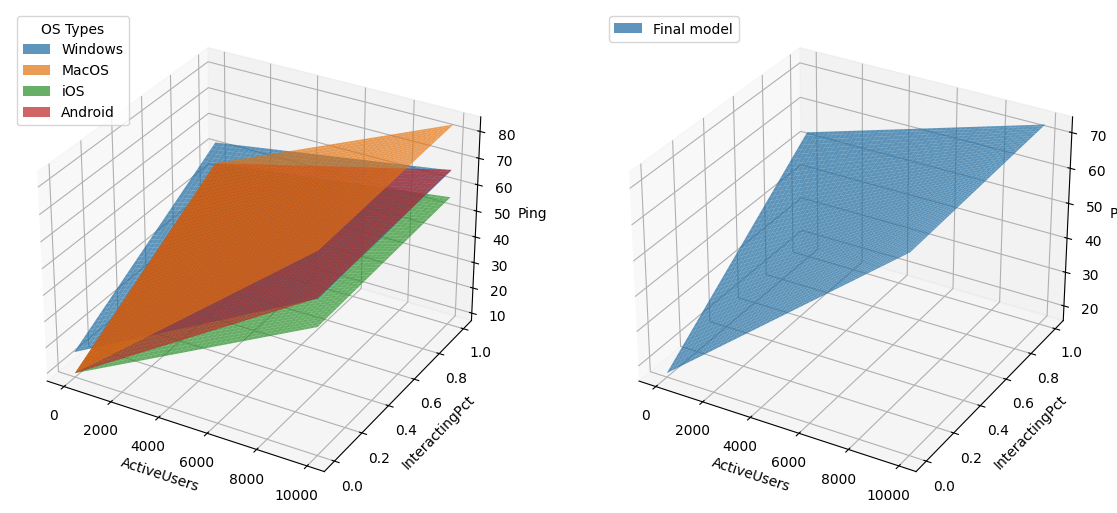

In [27]:
# plot for each OSType
fig, ax = plt.subplots(ncols=2, subplot_kw={"projection": "3d"}, figsize=(14, 7))
_ = ax[0].plot_surface(X1, X2, get_y("win", result, X1, X2), alpha=0.7, label="Windows")
_ = ax[0].plot_surface(X1, X2, get_y("mac", result, X1, X2), alpha=0.7, label="MacOS")
_ = ax[0].plot_surface(X1, X2, get_y("ios", result, X1, X2), alpha=0.7, label="iOS")
_ = ax[0].plot_surface(X1, X2, get_y("and", result, X1, X2), alpha=0.7, label="Android")
_ = ax[0].legend(loc="upper left", title="OS Types")
_ = ax[0].set(xlabel="ActiveUsers", ylabel="InteractingPct", zlabel="Ping")

Y = (            result.params.iloc[0]  # const
     + X1 *      result.params.iloc[1]  # ActiveUsers
     + X2 *      result.params.iloc[2]  # InteractingPct
     +           result.params.iloc[3]  # Windows
     + X1 * X2 * result.params.iloc[4]  # ActiveUsers * InteractingPct
     + X1 *      result.params.iloc[5]  # Windows * ActiveUsers
     + X1 *      result.params.iloc[6]  # MacOS * ActiveUsers
     + X1 *      result.params.iloc[7]) # iOS * ActiveUsers
_ = ax[1].plot_surface(X1, X2, Y, alpha=0.7, label="Final model")
_ = ax[1].set(xlabel="ActiveUsers", ylabel="InteractingPct", zlabel="Ping")
_ = ax[1].legend(loc="upper left")